In [27]:
import pandas as pd
import json
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

with open('/Users/jahnavikaranth/Downloads/All_Quiz_Questions.json', 'r') as file:
    data = json.load(file)

questions_df = pd.json_normalize(data['quiz']['questions'])
descriptions = questions_df['description']
solutions = questions_df['detailed_solution']

questions_df['questionId'] = questions_df['id']

def get_correct_answer_id(options):
    for option in options:
        if option.get('is_correct'):
            return option.get('id')
    return None  

questions_df['correctAnswerId'] = questions_df['options'].apply(get_correct_answer_id)

question_solution = [f"{desc} {sol}" for desc, sol in zip(descriptions, solutions)]

def preprocess_text(questions):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    processed_questions = []

    for question in questions:
        question = question.lower()
        question = re.sub(r'[^a-z\s]', '', question)
        
        tokens = question.split()

        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        processed_questions.append(' '.join(tokens))

    return processed_questions

preprocessed_questions = preprocess_text(question_solution)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(preprocessed_questions)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jahnavikaranth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jahnavikaranth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jahnavikaranth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


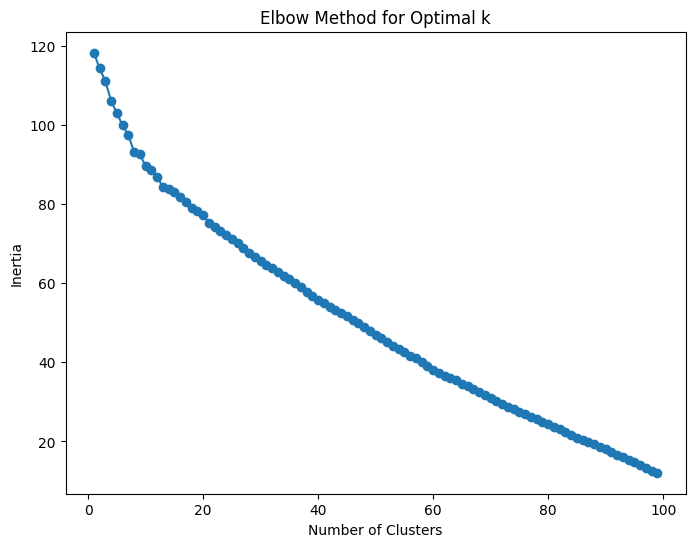

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for num_clusters in range(1, 100):  
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 100), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

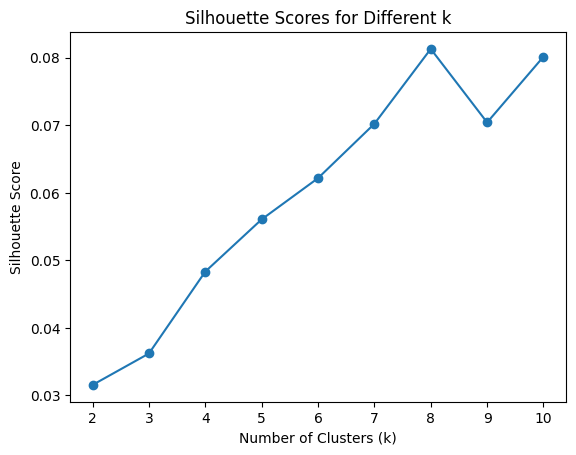

The optimal number of clusters is: 8


In [29]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters is: {optimal_k}")

In [30]:
optimal_clusters = optimal_k
kmeans = KMeans(n_clusters=optimal_clusters, random_state=10)
kmeans.fit(tfidf_matrix)
labels = kmeans.labels_

questions_df['Cluster ID'] = labels

def generate_cluster_labels(clusters, questions):
    labels = []
    for cluster_id, items in clusters.items():
        combined_text = " ".join(items)
        tokens = combined_text.split()
        filtered_words = [word for word in tokens if word not in stopwords.words('english')]
        if filtered_words:
            cluster_word_freq = Counter(filtered_words)
            most_common_in_cluster = cluster_word_freq.most_common(1)[0][0]
        else:
            most_common_in_cluster = f"Cluster_{cluster_id}"  
        labels.append(f"{most_common_in_cluster}_Cluster_{cluster_id}")
    return labels

clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(labels):
    clusters[label].append(preprocessed_questions[idx])

labels = generate_cluster_labels(clusters, preprocessed_questions)

questions_df["Label"] = questions_df["Cluster ID"].apply(
    lambda x: labels[x] if 0 <= x < len(labels) else "Unknown_Cluster"
)

final_table = questions_df[["description", "Cluster ID", "Label"]]

final_table['questionId'] = [questions_df.iloc[i]['questionId'] for i in range(len(final_table))]

final_table = final_table.merge(questions_df[['questionId', 'correctAnswerId']], on='questionId', how='left')

print(final_table)

final_table.to_csv('segmented_questions_with_labels.csv', index=False)
print("Data saved to segmented_questions_with_labels.csv")

                                           description  Cluster ID  \
0    The tissue which has free surface that faces e...           2   
1    Epithelial tissue is distinguished from connec...           2   
2    The ciliated columnar epithelial cells in huma...           1   
3                  The squamous epithelium is found in           1   
4    The kind of epithelium which forms the inner w...           1   
..                                                 ...         ...   
123  Bone is a solid, rigid connective tissue. If t...           0   
124  Neurons which connect the central nervous syst...           5   
125        Which type of neuron dominates in the CNS ?           5   
126  Mark the connective tissue which is without fi...           2   
127  The percentage of inorganic and organic parts ...           0   

                    Label  questionId  correctAnswerId  
0        tissue_Cluster_2        1827             7323  
1        tissue_Cluster_2        1828        

/var/folders/qr/phq7qqnx50vdzn6y778qf3mr0000gn/T/ipykernel_35270/464519407.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['questionId'] = [questions_df.iloc[i]['questionId'] for i in range(len(final_table))]


In [31]:
print(labels)

['bone_Cluster_0', 'epithelium_Cluster_1', 'tissue_Cluster_2', 'ligament_Cluster_3', 'cartilage_Cluster_4', 'muscle_Cluster_5', 'frog_Cluster_6', 'cell_Cluster_7']


In [32]:
import pandas as pd
import json

with open('/Users/jahnavikaranth/Downloads/Current_Test.json', 'r') as file:
    data = json.load(file)

curr_test_df = pd.json_normalize(data)

print(curr_test_df.head())





       id  quiz_id                       user_id  \
0  336566       43  7ZXdz3zHuNcdg9agb5YpaOGLQqw2   

                    submitted_at                     created_at  \
0  2025-01-17T15:51:29.859+05:30  2025-01-17T15:51:29.871+05:30   

                      updated_at  score  trophy_level accuracy speed  ...  \
0  2025-01-17T15:51:29.871+05:30     32             2     80 %   100  ...   

  quiz.exam_id quiz.show_unanswered  quiz.ends_at  quiz.lives quiz.live_count  \
0         None                False    2025-01-18        None       Free Test   

  quiz.coin_count quiz.questions_count   quiz.daily_date  \
0              -1                  128  January 17, 2025   

  quiz.max_mistake_count  quiz.reading_materials  
0                     15                      []  

[1 rows x 68 columns]


In [33]:
curr_test_df

,id,quiz_id,user_id,submitted_at,created_at,updated_at,score,trophy_level,accuracy,speed,...,quiz.exam_id,quiz.show_unanswered,quiz.ends_at,quiz.lives,quiz.live_count,quiz.coin_count,quiz.questions_count,quiz.daily_date,quiz.max_mistake_count,quiz.reading_materials
0,336566,43,7ZXdz3zHuNcdg9agb5YpaOGLQqw2,2025-01-17T15:51:29.859+05:30,2025-01-17T15:51:29.871+05:30,2025-01-17T15:51:29.871+05:30,32,2,80 %,100,...,None,False,2025-01-18,None,Free Test,-1,128,"January 17, 2025",15,[]


In [34]:
import pandas as pd
import json

with open('/Users/jahnavikaranth/Downloads/Current_Test.json', 'r') as file:
    data = json.load(file)

response_map = data.get('response_map', {})

print(response_map)

{'1837': 7363, '1848': 7407, '1852': 7423, '1862': 7464, '1877': 7525, '1878': 7529, '1900': 7617, '1917': 7685, '1934': 7750, '1964': 7872}


In [35]:


final_df = pd.DataFrame(final_table)
response_map_df = pd.DataFrame(list(response_map.items()), columns=["questionId", "answer_given"])
response_map_df['questionId'] = response_map_df['questionId'].astype(str)
final_df['questionId'] = final_df['questionId'].astype(str)

merged_df = pd.merge(response_map_df, final_df, on="questionId", how="left")

merged_df['is_correct'] = merged_df.apply(lambda row: row['correctAnswerId'] == row['answer_given'], axis=1)

print(merged_df)

  questionId  answer_given                                        description  \
0       1837          7363  Which of the following statement(s) regarding ...   
1       1848          7407  Which of the following types of connective tis...   
2       1852          7423                 Choose the correctly matched pair.   
3       1862          7464  The secretions of endocrine glands are release...   
4       1877          7525                                    Frog's heart is   
5       1878          7529  Vasa efferentia in male frog, enter the kidney...   
6       1900          7617    Gland which is both exocrine and endocrine is :   
7       1917          7685  All the following cells produces collagen exce...   
8       1934          7750                          Hyaline cartilage forms :   
9       1964          7872  The percentage of inorganic and organic parts ...   

   Cluster ID                Label  correctAnswerId  is_correct  
0           7       cell_Cluster_7        

                 Label  correct_percentage      Performance
0       bone_Cluster_0           66.666667       Needs Work
1  cartilage_Cluster_4          100.000000        Very Good
2       cell_Cluster_7          100.000000        Very Good
3       frog_Cluster_6           50.000000  Needs Hard Work
4     tissue_Cluster_2          100.000000        Very Good


/var/folders/qr/phq7qqnx50vdzn6y778qf3mr0000gn/T/ipykernel_35270/3325816766.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_performance = merged_df.groupby('Label').apply(


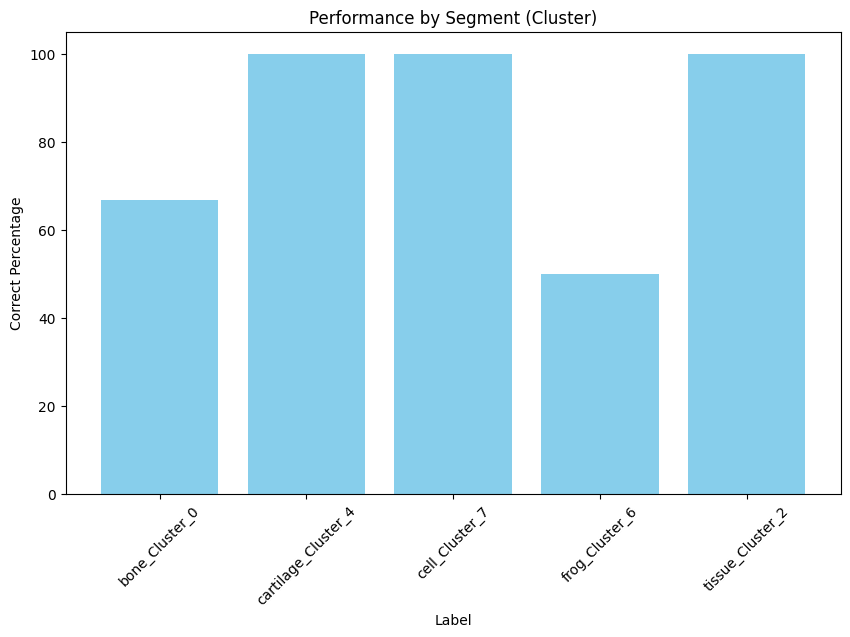

In [36]:
import pandas as pd


cluster_performance = merged_df.groupby('Label').apply(
    lambda group: pd.Series({
        'total_answers': group.shape[0],
        'correct_answers': group['is_correct'].sum(),
        'correct_percentage': group['is_correct'].mean() * 100
    })
).reset_index()

def classify_performance(row):
    if row['correct_percentage'] == 100:
        return 'Very Good'
    elif row['correct_percentage'] >= 60:
        return 'Needs Work'
    elif row['correct_percentage'] >= 40:
        return 'Needs Hard Work'
    else:
        return 'Very Bad'

cluster_performance['Performance'] = cluster_performance.apply(classify_performance, axis=1)

print(cluster_performance[['Label', 'correct_percentage', 'Performance']])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(cluster_performance['Label'], cluster_performance['correct_percentage'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Correct Percentage')
plt.title('Performance by Segment (Cluster)')
plt.xticks(rotation=45)
plt.show()

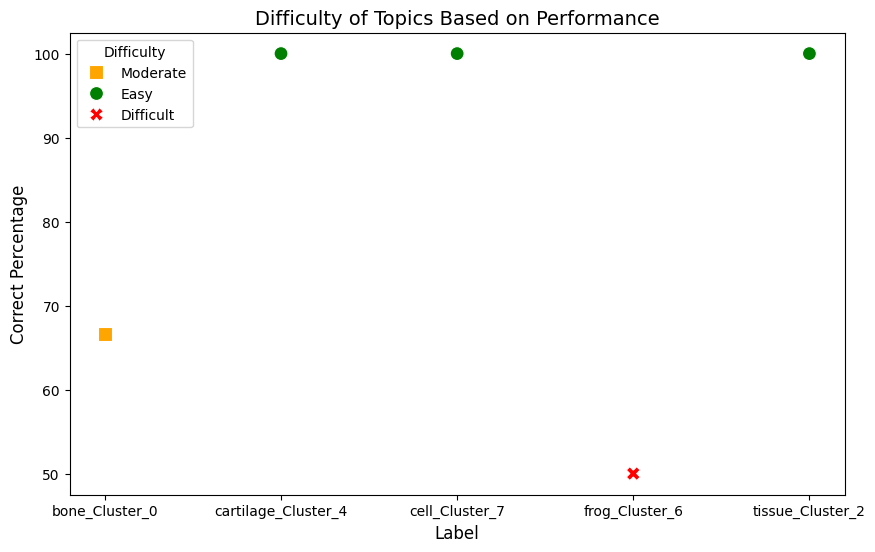

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


def classify_difficulty(row):
    if row['correct_percentage'] >= 80:
        return 'Easy'
    elif row['correct_percentage'] >= 60:
        return 'Moderate'
    else:
        return 'Difficult'

cluster_performance['Difficulty'] = cluster_performance.apply(classify_difficulty, axis=1)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=cluster_performance, 
                x='Label', 
                y='correct_percentage', 
                hue='Difficulty', 
                palette={'Easy': 'green', 'Moderate': 'orange', 'Difficult': 'red'}, 
                style='Difficulty', 
                markers={'Easy': 'o', 'Moderate': 's', 'Difficult': 'X'}, 
                s=100)

plt.title('Difficulty of Topics Based on Performance', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Correct Percentage', fontsize=12)
plt.legend(title='Difficulty', loc='upper left')

plt.show()

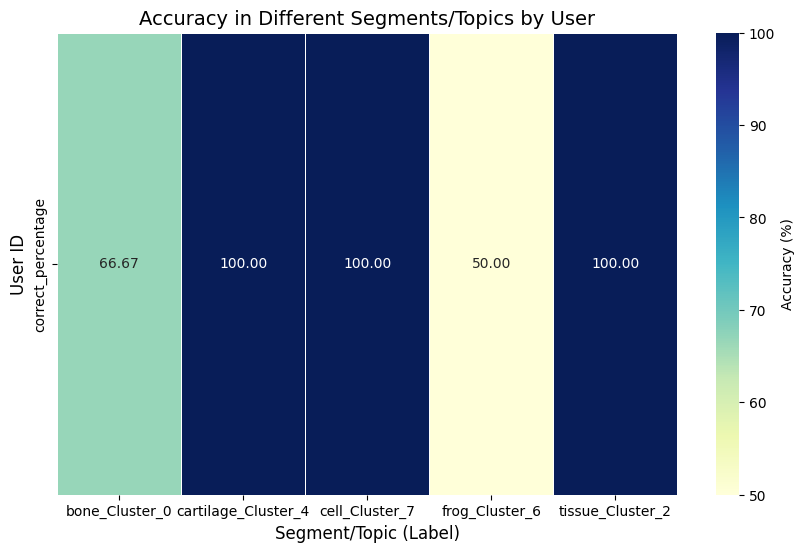

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


pivot_table = cluster_performance.pivot_table(values='correct_percentage', columns='Label')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Accuracy (%)'})

plt.title('Accuracy in Different Segments/Topics by User', fontsize=14)
plt.xlabel('Segment/Topic (Label)', fontsize=12)
plt.ylabel('User ID', fontsize=12)

plt.show()